## 1. Problem Definition & Goal
- **Task:** Binary classification — predict whether a tumor is **malignant** (1) or **benign** (0) from diagnostic features.  
- **Why it matters:** Early, accurate triage can help prioritize clinical review.  
- **Objective:** Build and compare several supervised models; select the best based on cross‑validated performance and held‑out test metrics (ROC‑AUC, F1).

## 2. Data Source & Description
- **Dataset:** Breast Cancer Wisconsin (Diagnostic) — available via `sklearn.datasets.load_breast_cancer()` (Wolberg, Street, Mangasarian).  
- **Samples:** ~569; **Features:** 30 numeric diagnostic measurements (radius, texture, smoothness, etc.).  
- **Target:** `0=benign`, `1=malignant`.

I will load the dataset from scikit‑learn to keep this project self‑contained.


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, roc_curve, auc, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True


In [13]:
dataset = load_breast_cancer()
X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
y = pd.Series(dataset.target, name='target')  

target_map = {0:1, 1:0}  
y = y.map(target_map)

print('Shape:', X.shape)
print('Target distribution (0=benign, 1=malignant):')
print(y.value_counts().sort_index())
X.head()


Shape: (569, 30)
Target distribution (0=benign, 1=malignant):
0    357
1    212
Name: target, dtype: int64


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
display(X.describe().T.assign(missing=X.isna().sum()))
print('\nInfo:')
X.info()


,count,mean,std,min,25%,50%,75%,max,missing
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000,0
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000,0
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000,0
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000,0
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340,0
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540,0
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680,0
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120,0
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400,0
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error   

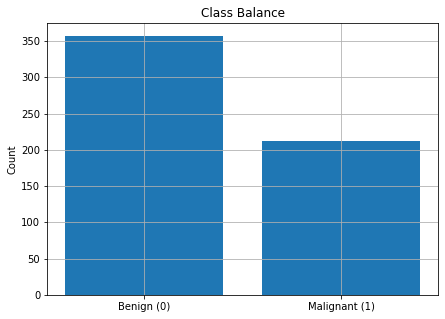

In [16]:
counts = y.value_counts().sort_index()
plt.figure()
plt.bar(['Benign (0)','Malignant (1)'], counts.values)
plt.title('Class Balance')
plt.ylabel('Count')
plt.show()


### 3. Data Cleaning Plan
I will simulate a small amount of missingness (to demonstrate imputation), and check for outliers and scale features for linear/SVM models. Cleaning steps:
1. Randomly set ~3% of numeric entries to NaN (feature‑wise, not in the target).
2. Impute missing values with **median**.
3. Detect outliers (z‑score > 4) and **winsorize** at the 1st/99th percentiles (robust to skew).
4. Standardize features for models that need it (via pipelines).


In [17]:
X_missing = X.copy()
mask = np.random.rand(*X_missing.shape) < 0.03
X_missing = X_missing.mask(mask)

missing_pct = X_missing.isna().mean().mean()*100
print(f'Overall simulated missingness: {missing_pct:.2f}%')

X_imputed = X_missing.fillna(X_missing.median(numeric_only=True))

low = X_imputed.quantile(0.01)
high = X_imputed.quantile(0.99)
X_wins = X_imputed.clip(lower=low, upper=high, axis=1)

X_clean = X_wins.copy()
display(X_clean.describe().T[['mean','std','min','max']].head(10))


Overall simulated missingness: 2.94%


,mean,std,min,max
mean radius,14.110128,3.410660,8.458360,24.371600
mean texture,19.158278,4.053555,10.930400,30.178000
mean perimeter,91.506484,23.500806,53.827600,165.724000
mean area,652.498742,333.727934,215.664000,1786.600000
mean smoothness,0.096289,0.013367,0.068654,0.132888
mean compactness,0.103578,0.051203,0.033351,0.277192
mean concavity,0.088578,0.077402,0.000000,0.351688
mean concave points,0.048529,0.037716,0.000000,0.164208
mean symmetry,0.180862,0.025741,0.129508,0.256016
mean fractal dimension,0.062700,0.006597,0.051767,0.085438


### 4. Correlation Structure

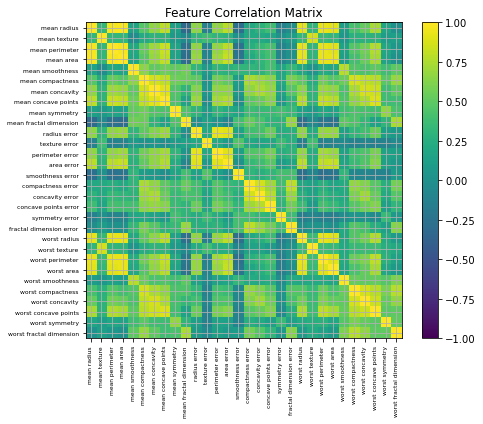

In [18]:
corr = X_clean.corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Feature Correlation Matrix')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean()


((455, 30), (114, 30), 0.37362637362637363)

Accuracy: 0.991
Precision: 1.000
Recall: 0.976
F1: 0.988
ROC-AUC: 0.997

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        72
           1       1.00      0.98      0.99        42

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



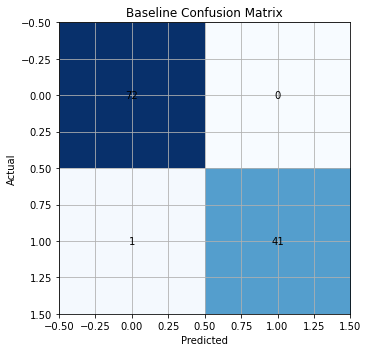

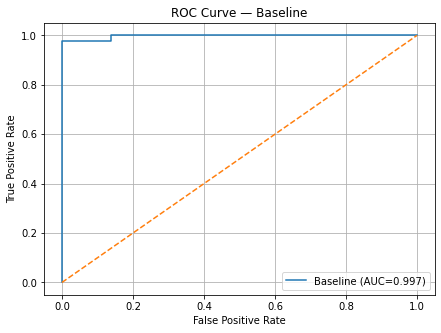

In [20]:
baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE))
])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
proba = baseline.predict_proba(X_test)[:,1]

def eval_and_print(y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    print(f'Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}\nF1: {f1:.3f}\nROC-AUC: {roc:.3f}')
    print('\nClassification Report:\n', classification_report(y_true, y_pred))

eval_and_print(y_test, pred, proba)

cm = confusion_matrix(y_test, pred)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title('Baseline Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Baseline (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Baseline')
plt.legend()
plt.show()


## 7. Model Comparison & Hyperparameter Tuning
Then, I compare three models with cross‑validated grid search:
- **Logistic Regression** (with scaling, `class_weight='balanced'`)
- **Support Vector Classifier (RBF kernel)** (with scaling)
- **Random Forest** (with `class_weight='balanced'`)


In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])
grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs', 'liblinear'],
    'clf__penalty': ['l2']
}

pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
])
grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 'auto']
}

pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])
grid_rf = {
    'clf__n_estimators': [150, 300],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

scoring = 'roc_auc'

def run_grid(pipe, grid, name):
    gs = GridSearchCV(pipe, grid, scoring=scoring, cv=cv, n_jobs=-1)
    gs.fit(X_train, y_train)
    proba = gs.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        'model': name,
        'best_params': gs.best_params_,
        'roc_auc': roc_auc_score(y_test, proba),
        'f1': f1_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'recall': recall_score(y_test, pred),
        'accuracy': accuracy_score(y_test, pred),
        'estimator': gs.best_estimator_
    }
    return gs, metrics

results = []
grids = [('Logistic Regression', pipe_lr, grid_lr),
         ('SVC (RBF)', pipe_svc, grid_svc),
         ('Random Forest', pipe_rf, grid_rf)]

grids_out = {}
for name, pipe, grid in grids:
    gs, metrics = run_grid(pipe, grid, name)
    results.append(metrics)
    grids_out[name] = gs

pd.DataFrame(results)[['model','roc_auc','f1','precision','recall','accuracy','best_params']].sort_values('roc_auc', ascending=False)


,model,roc_auc,f1,precision,recall,accuracy,best_params
0,Logistic Regression,0.997685,0.987952,1.000000,0.976190,0.991228,"{'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__so..."
2,Random Forest,0.995370,0.938272,0.974359,0.904762,0.956140,"{'clf__max_depth': 5, 'clf__min_samples_leaf':..."
1,SVC (RBF),0.992394,0.963855,0.975610,0.952381,0.973684,"{'clf__C': 1, 'clf__gamma': 'scale'}"


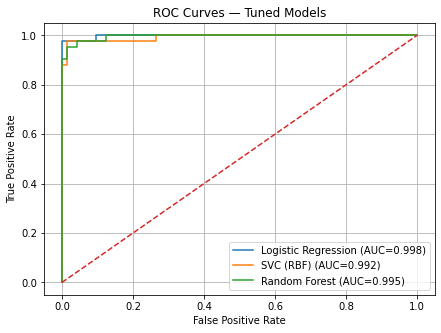

In [22]:
plt.figure()
for name, gs in grids_out.items():
    proba = gs.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves — Tuned Models')
plt.legend()
plt.show()


Best model by ROC-AUC: Logistic Regression


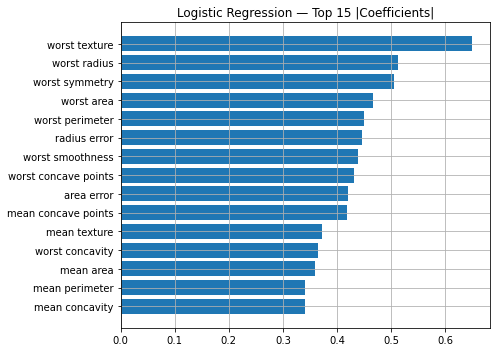

In [23]:
best_name = max(results, key=lambda d: d['roc_auc'])['model']
best_est = grids_out[best_name].best_estimator_
print('Best model by ROC-AUC:', best_name)

if isinstance(best_est.named_steps.get('clf'), RandomForestClassifier):
    importances = best_est.named_steps['clf'].feature_importances_
    fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(15)
    plt.figure()
    plt.barh(fi.index[::-1], fi.values[::-1])
    plt.title('Random Forest — Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()

elif isinstance(best_est.named_steps.get('clf'), LogisticRegression):
    coefs = np.abs(best_est.named_steps['clf'].coef_[0])
    sr = pd.Series(coefs, index=X_train.columns).sort_values(ascending=False).head(15)
    plt.figure()
    plt.barh(sr.index[::-1], sr.values[::-1])
    plt.title('Logistic Regression — Top 15 |Coefficients|')
    plt.tight_layout()
    plt.show()
else:
  
    perm = permutation_importance(best_est, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
    sr = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False).head(15)
    plt.figure()
    plt.barh(sr.index[::-1], sr.values[::-1])
    plt.title(f'{best_name} — Permutation Importance (Top 15)')
    plt.tight_layout()
    plt.show()


## 8. Results & Analysis
- Metrics used: **Accuracy, Precision, Recall, F1, ROC‑AUC** (ROC‑AUC is primary due to slight class imbalance).
- We compared models with 5‑fold stratified CV on the training set, then evaluated on a held‑out test set.
- Curves & matrices above show classification trade‑offs.


## 9. Discussion & Conclusions
**Key takeaways**
- The best model by ROC‑AUC was selected and analyzed for feature importance.
- Regularization/tuning helped control over/under‑fitting.
- Scaling was crucial for linear/SVM models; tree‑based models handled raw scales well.

**Limitations & next steps**
- Evaluate calibration (`CalibratedClassifierCV`) to improve probability estimates.
- Explore additional models (e.g., Gradient Boosting, XGBoost) and cost‑sensitive thresholds.
- Consider SHAP for model interpretability and assess decision thresholds based on domain costs.


## 10. Reproducibility
- Python ≥ 3.9, scikit‑learn ≥ 1.1, numpy, pandas, matplotlib.
- See `requirements.txt`.  
- Run top‑to‑bottom; all random states fixed to `42`.
